In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has two classes: whether stock will go up or down or stay constant X days after last input.

In [1]:
OBSERVATION_TIME = 120
PREDICTION_AFTER_DAYS = 5
EPOCHS = 200
TEST_SIZE = 0.1
RANDOM_SPLIT = True
NORMALIZED_CHUNKS = True

In [2]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/sp500_20Y_without_covid.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


In [3]:
def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

In [4]:
observed_chunks[0]

,index,Date,Open,High,Low,Close,Adj Close,Volume
0,0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000
...,...,...,...,...,...,...,...,...
115,115,2000-08-04,1452.560059,1462.930054,1451.310059,1462.930054,1462.930054,956000000
116,116,2000-08-07,1462.930054,1480.800049,1460.719971,1479.319946,1479.319946,854800000
117,117,2000-08-08,1479.319946,1484.520020,1472.609985,1482.800049,1482.800049,992200000
118,118,2000-08-09,1482.800049,1490.329956,1471.160034,1472.869995,1472.869995,1054000000


In [5]:
def normalize_chunk(chunk):
    df = chunk.copy()
    for label_to_normalize in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
        np_arr = df[label_to_normalize].to_numpy()
        df[label_to_normalize] = pd.Series((np.array(np_arr) - np.mean(np_arr)) / np.std(np_arr))
    return df

def normalize_chunks(chunks):
    return list(map(lambda x: normalize_chunk(x), chunks))

observed_chunks = normalize_chunks(observed_chunks) if NORMALIZED_CHUNKS else observed_chunks

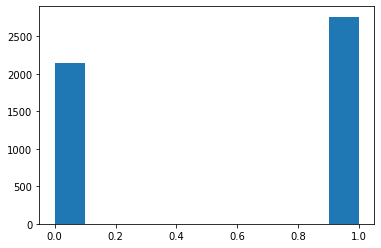

1    2761
0    2144
dtype: int64

In [6]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

In [7]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (OBSERVATION_TIME, 5), filters=16, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 120, 16)           336       
_________________________________________________________________
batch_normalization_1 (Batch (None, 120, 16)           64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 120, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 16)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 8)            520       
_________________________________________________________________
batch_normalization_2 (Batch (None, 120, 8)            32        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 120, 8)           

In [8]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [9]:
from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4414, 120, 5), (4414,), (491, 120, 5), (491,))

In [10]:
import random

def undersample_and_shuffle(X, Y):
    count_class_1, count_class_0 = pd.Series(Y).value_counts()

    lower_count = count_class_0 if count_class_0 < count_class_1 else count_class_1
    lower_class = 0 if count_class_0 < count_class_1 else 1
    
    diff = abs(count_class_0 - count_class_1)
    
    vec0 = random.sample([(x, y) for x, y in zip(X, Y) if y == 0], lower_count)
    vec1 = random.sample([(x, y) for x, y in zip(X, Y) if y == 1], lower_count)

    
    vec = vec0 + vec1
    random.shuffle(vec)
    return np.array(list(map(lambda x: x[0], vec))), np.array(list(map(lambda x: x[1], vec)))
    
X_train_balanced, Y_train_balanced = undersample_and_shuffle(X_train, Y_train)

In [11]:
pd.Series(Y_test).value_counts()

1.0    299
0.0    192
dtype: int64

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="model-binary.hdf5", save_best_only=True)

history = model.fit(x=X_train_balanced, 
                    y=Y_train_balanced, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True,
                    callbacks = [checkpointer])

Train on 3904 samples, validate on 491 samples
Epoch 1/200
3904/3904 [==============================] - 1s 283us/step - loss: 0.7714 - tp: 1085.0000 - fp: 1085.0000 - tn: 867.0000 - fn: 867.0000 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.5558 - auc: 0.4979 - val_loss: 0.7365 - val_tp: 99.0000 - val_fp: 59.0000 - val_tn: 133.0000 - val_fn: 200.0000 - val_accuracy: 0.4725 - val_precision: 0.6266 - val_recall: 0.3311 - val_auc: 0.5484
Epoch 2/200
3904/3904 [==============================] - 0s 118us/step - loss: 0.7213 - tp: 1052.0000 - fp: 933.0000 - tn: 1019.0000 - fn: 900.0000 - accuracy: 0.5305 - precision: 0.5300 - recall: 0.5389 - auc: 0.5380 - val_loss: 0.6982 - val_tp: 168.0000 - val_fp: 103.0000 - val_tn: 89.0000 - val_fn: 131.0000 - val_accuracy: 0.5234 - val_precision: 0.6199 - val_recall: 0.5619 - val_auc: 0.5386
Epoch 3/200
3904/3904 [==============================] - 0s 111us/step - loss: 0.7186 - tp: 988.0000 - fp: 932.0000 - tn: 1020.0000 - fn: 964.0000 - accuracy:

3904/3904 [==============================] - 0s 103us/step - loss: 0.6705 - tp: 1131.0000 - fp: 811.0000 - tn: 1141.0000 - fn: 821.0000 - accuracy: 0.5820 - precision: 0.5824 - recall: 0.5794 - auc: 0.6190 - val_loss: 0.6978 - val_tp: 144.0000 - val_fp: 78.0000 - val_tn: 114.0000 - val_fn: 155.0000 - val_accuracy: 0.5255 - val_precision: 0.6486 - val_recall: 0.4816 - val_auc: 0.5670
Epoch 22/200
3904/3904 [==============================] - 0s 100us/step - loss: 0.6667 - tp: 1172.0000 - fp: 841.0000 - tn: 1111.0000 - fn: 780.0000 - accuracy: 0.5848 - precision: 0.5822 - recall: 0.6004 - auc: 0.6264 - val_loss: 0.6944 - val_tp: 121.0000 - val_fp: 58.0000 - val_tn: 134.0000 - val_fn: 178.0000 - val_accuracy: 0.5193 - val_precision: 0.6760 - val_recall: 0.4047 - val_auc: 0.5694
Epoch 23/200
3904/3904 [==============================] - 0s 107us/step - loss: 0.6647 - tp: 1155.0000 - fp: 799.0000 - tn: 1153.0000 - fn: 797.0000 - accuracy: 0.5912 - precision: 0.5911 - recall: 0.5917 - auc: 0.6

Epoch 42/200
3904/3904 [==============================] - 0s 102us/step - loss: 0.6333 - tp: 1251.0000 - fp: 693.0000 - tn: 1259.0000 - fn: 701.0000 - accuracy: 0.6429 - precision: 0.6435 - recall: 0.6409 - auc: 0.6940 - val_loss: 0.6804 - val_tp: 165.0000 - val_fp: 82.0000 - val_tn: 110.0000 - val_fn: 134.0000 - val_accuracy: 0.5601 - val_precision: 0.6680 - val_recall: 0.5518 - val_auc: 0.5982
Epoch 43/200
3904/3904 [==============================] - 0s 104us/step - loss: 0.6344 - tp: 1219.0000 - fp: 715.0000 - tn: 1237.0000 - fn: 733.0000 - accuracy: 0.6291 - precision: 0.6303 - recall: 0.6245 - auc: 0.6883 - val_loss: 0.6865 - val_tp: 154.0000 - val_fp: 69.0000 - val_tn: 123.0000 - val_fn: 145.0000 - val_accuracy: 0.5642 - val_precision: 0.6906 - val_recall: 0.5151 - val_auc: 0.5980
Epoch 44/200
3904/3904 [==============================] - 0s 103us/step - loss: 0.6313 - tp: 1247.0000 - fp: 687.0000 - tn: 1265.0000 - fn: 705.0000 - accuracy: 0.6434 - precision: 0.6448 - recall: 0.63

Epoch 63/200
3904/3904 [==============================] - 0s 103us/step - loss: 0.5971 - tp: 1282.0000 - fp: 615.0000 - tn: 1337.0000 - fn: 670.0000 - accuracy: 0.6709 - precision: 0.6758 - recall: 0.6568 - auc: 0.7409 - val_loss: 0.6824 - val_tp: 158.0000 - val_fp: 68.0000 - val_tn: 124.0000 - val_fn: 141.0000 - val_accuracy: 0.5743 - val_precision: 0.6991 - val_recall: 0.5284 - val_auc: 0.6198
Epoch 64/200
3904/3904 [==============================] - 0s 103us/step - loss: 0.5992 - tp: 1322.0000 - fp: 637.0000 - tn: 1315.0000 - fn: 630.0000 - accuracy: 0.6755 - precision: 0.6748 - recall: 0.6773 - auc: 0.7411 - val_loss: 0.6759 - val_tp: 172.0000 - val_fp: 67.0000 - val_tn: 125.0000 - val_fn: 127.0000 - val_accuracy: 0.6049 - val_precision: 0.7197 - val_recall: 0.5753 - val_auc: 0.6327
Epoch 65/200
3904/3904 [==============================] - 0s 105us/step - loss: 0.5956 - tp: 1343.0000 - fp: 644.0000 - tn: 1308.0000 - fn: 609.0000 - accuracy: 0.6790 - precision: 0.6759 - recall: 0.68

Epoch 84/200
3904/3904 [==============================] - 0s 106us/step - loss: 0.5517 - tp: 1404.0000 - fp: 566.0000 - tn: 1386.0000 - fn: 548.0000 - accuracy: 0.7147 - precision: 0.7127 - recall: 0.7193 - auc: 0.7954 - val_loss: 0.6813 - val_tp: 171.0000 - val_fp: 65.0000 - val_tn: 127.0000 - val_fn: 128.0000 - val_accuracy: 0.6069 - val_precision: 0.7246 - val_recall: 0.5719 - val_auc: 0.6303
Epoch 85/200
3904/3904 [==============================] - 0s 110us/step - loss: 0.5510 - tp: 1432.0000 - fp: 553.0000 - tn: 1399.0000 - fn: 520.0000 - accuracy: 0.7252 - precision: 0.7214 - recall: 0.7336 - auc: 0.7966 - val_loss: 0.6858 - val_tp: 163.0000 - val_fp: 63.0000 - val_tn: 129.0000 - val_fn: 136.0000 - val_accuracy: 0.5947 - val_precision: 0.7212 - val_recall: 0.5452 - val_auc: 0.6342
Epoch 86/200
3904/3904 [==============================] - 0s 110us/step - loss: 0.5490 - tp: 1400.0000 - fp: 539.0000 - tn: 1413.0000 - fn: 552.0000 - accuracy: 0.7205 - precision: 0.7220 - recall: 0.71

3904/3904 [==============================] - 0s 102us/step - loss: 0.5173 - tp: 1451.0000 - fp: 507.0000 - tn: 1445.0000 - fn: 501.0000 - accuracy: 0.7418 - precision: 0.7411 - recall: 0.7433 - auc: 0.8263 - val_loss: 0.6870 - val_tp: 158.0000 - val_fp: 61.0000 - val_tn: 131.0000 - val_fn: 141.0000 - val_accuracy: 0.5886 - val_precision: 0.7215 - val_recall: 0.5284 - val_auc: 0.6401
Epoch 105/200
3904/3904 [==============================] - 0s 100us/step - loss: 0.5186 - tp: 1445.0000 - fp: 514.0000 - tn: 1438.0000 - fn: 507.0000 - accuracy: 0.7385 - precision: 0.7376 - recall: 0.7403 - auc: 0.8242 - val_loss: 0.6777 - val_tp: 161.0000 - val_fp: 66.0000 - val_tn: 126.0000 - val_fn: 138.0000 - val_accuracy: 0.5845 - val_precision: 0.7093 - val_recall: 0.5385 - val_auc: 0.6533
Epoch 106/200
3904/3904 [==============================] - 0s 102us/step - loss: 0.5077 - tp: 1458.0000 - fp: 479.0000 - tn: 1473.0000 - fn: 494.0000 - accuracy: 0.7508 - precision: 0.7527 - recall: 0.7469 - auc: 0

3904/3904 [==============================] - 0s 100us/step - loss: 0.4829 - tp: 1495.0000 - fp: 441.0000 - tn: 1511.0000 - fn: 457.0000 - accuracy: 0.7700 - precision: 0.7722 - recall: 0.7659 - auc: 0.8546 - val_loss: 0.6812 - val_tp: 162.0000 - val_fp: 64.0000 - val_tn: 128.0000 - val_fn: 137.0000 - val_accuracy: 0.5906 - val_precision: 0.7168 - val_recall: 0.5418 - val_auc: 0.6674
Epoch 125/200
3904/3904 [==============================] - 0s 106us/step - loss: 0.4817 - tp: 1507.0000 - fp: 439.0000 - tn: 1513.0000 - fn: 445.0000 - accuracy: 0.7736 - precision: 0.7744 - recall: 0.7720 - auc: 0.8553 - val_loss: 0.6761 - val_tp: 168.0000 - val_fp: 60.0000 - val_tn: 132.0000 - val_fn: 131.0000 - val_accuracy: 0.6110 - val_precision: 0.7368 - val_recall: 0.5619 - val_auc: 0.6712
Epoch 126/200
3904/3904 [==============================] - 0s 108us/step - loss: 0.4771 - tp: 1518.0000 - fp: 418.0000 - tn: 1534.0000 - fn: 434.0000 - accuracy: 0.7818 - precision: 0.7841 - recall: 0.7777 - auc: 0

3904/3904 [==============================] - 0s 99us/step - loss: 0.4604 - tp: 1520.0000 - fp: 430.0000 - tn: 1522.0000 - fn: 432.0000 - accuracy: 0.7792 - precision: 0.7795 - recall: 0.7787 - auc: 0.8670 - val_loss: 0.6678 - val_tp: 180.0000 - val_fp: 61.0000 - val_tn: 131.0000 - val_fn: 119.0000 - val_accuracy: 0.6334 - val_precision: 0.7469 - val_recall: 0.6020 - val_auc: 0.6857
Epoch 145/200
3904/3904 [==============================] - 0s 101us/step - loss: 0.4506 - tp: 1555.0000 - fp: 419.0000 - tn: 1533.0000 - fn: 397.0000 - accuracy: 0.7910 - precision: 0.7877 - recall: 0.7966 - auc: 0.8753 - val_loss: 0.6828 - val_tp: 167.0000 - val_fp: 59.0000 - val_tn: 133.0000 - val_fn: 132.0000 - val_accuracy: 0.6110 - val_precision: 0.7389 - val_recall: 0.5585 - val_auc: 0.6760
Epoch 146/200
3904/3904 [==============================] - 0s 98us/step - loss: 0.4501 - tp: 1542.0000 - fp: 426.0000 - tn: 1526.0000 - fn: 410.0000 - accuracy: 0.7859 - precision: 0.7835 - recall: 0.7900 - auc: 0.8

Epoch 165/200
3904/3904 [==============================] - 0s 101us/step - loss: 0.4116 - tp: 1607.0000 - fp: 363.0000 - tn: 1589.0000 - fn: 345.0000 - accuracy: 0.8186 - precision: 0.8157 - recall: 0.8233 - auc: 0.8999 - val_loss: 0.6875 - val_tp: 179.0000 - val_fp: 62.0000 - val_tn: 130.0000 - val_fn: 120.0000 - val_accuracy: 0.6293 - val_precision: 0.7427 - val_recall: 0.5987 - val_auc: 0.6867
Epoch 166/200
3904/3904 [==============================] - 0s 99us/step - loss: 0.4269 - tp: 1565.0000 - fp: 397.0000 - tn: 1555.0000 - fn: 387.0000 - accuracy: 0.7992 - precision: 0.7977 - recall: 0.8017 - auc: 0.8891 - val_loss: 0.6690 - val_tp: 187.0000 - val_fp: 56.0000 - val_tn: 136.0000 - val_fn: 112.0000 - val_accuracy: 0.6578 - val_precision: 0.7695 - val_recall: 0.6254 - val_auc: 0.7013
Epoch 167/200
3904/3904 [==============================] - 0s 99us/step - loss: 0.4114 - tp: 1599.0000 - fp: 366.0000 - tn: 1586.0000 - fn: 353.0000 - accuracy: 0.8158 - precision: 0.8137 - recall: 0.8

In [ ]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall', 'accuracy']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    
    plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])

plt.show()